# Imports

In [4]:
import os
import math
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset
import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, LMCVariationalStrategy
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import optuna
from optuna import Trial

import pickle

In [5]:
# Run id setup
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

date = '26-08-2024'
version = 'v1'
run_id = date + '_' + version

# Create a folder if it doesn't exist
folder_path = f'{run_id}'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Cuda Initialization

In [6]:
cuda_available = torch.cuda.is_available()

device = torch.device('cuda' if cuda_available else 'cpu')

print(f'Using device: {device}')
if cuda_available:
    print("Number of GPUs available:", torch.cuda.device_count())
    print("Current GPU:", torch.cuda.current_device())
    print("GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

Using device: cpu


# Dataset Creation and Loading

In [7]:
dataset = pd.read_csv('../Dataset/dataset.csv')
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['Day'] = dataset['Date'].dt.day
dataset['Month'] = dataset['Date'].dt.month
dataset['Year'] = dataset['Date'].dt.year
dataset['Weekday'] = dataset['Date'].dt.weekday
dataset['Quarter'] = dataset['Date'].dt.quarter
dataset['DayOfYear'] = dataset['Date'].dt.dayofyear

dataset = dataset.sample(frac=0.1, random_state=42)

In [8]:
target_vars = ['CO', 'NO', 'NO2', 'NOX', 'O3', 'PM10', 'PM2.5']

X = dataset.drop(columns=['Date', 'Nombre_Estacion', 'Clave_Estacion'] + target_vars)  # Adjust columns as needed
y = dataset[target_vars]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

# Scale y
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

batch_size = 1000  # Adjust batch size as needed

pollution_dataset_train = TensorDataset(X_train, y_train)
train_loader = DataLoader(pollution_dataset_train, batch_size=batch_size, shuffle=True)

torch.Size([16464, 16]) torch.Size([16464, 7])
torch.Size([4116, 16]) torch.Size([4116, 7])


# Model Creation

In [9]:
class MultitaskGPModel(ApproximateGP):
    def __init__(self, num_latents, num_tasks, num_features):
        # Let's use a different set of inducing points for each latent function
        inducing_points = torch.rand(num_latents, num_features, num_features).to(device)
        
        # We have to mark the CholeskyVariationalDistribution as batch
        # so that we learn a variational distribution for each task
        variational_distribution = CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents])
        )
        
        # We have to wrap the VariationalStrategy in a LMCVariationalStrategy
        # so that the output will be a MultitaskMultivariateNormal rather than a batch output
        variational_strategy = LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=num_tasks,
            num_latents=num_latents,
            latent_dim=-1
        )

        super().__init__(variational_strategy)

        # The mean and covariance modules should be marked as batch
        # so we learn a different set of hyperparameters
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents]), ard_num_dims=num_features),  # Adjust for ARD
            batch_shape=torch.Size([num_latents])
        )
        
    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [10]:
def objective(trial: Trial):
    # Suggest hyperparameters to optimize
    num_latents = trial.suggest_int('num_latents', 1, 10)  # Vary the number of latent functions
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)  # Log-uniform sampling for learning rate
    batch_size = trial.suggest_categorical('batch_size', [500, 1000, 2000])  # Different batch sizes
    
    # Redefine your model and optimizer with suggested hyperparameters
    model = MultitaskGPModel(num_latents=num_latents, num_tasks=y.shape[-1], num_features=X.shape[-1]).to(device)
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=y.shape[-1]).to(device)
    
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam([
        {'params': model.parameters()},
        {'params': likelihood.parameters()},
    ], lr=lr)

    # Use the same MLL (marginal log likelihood)
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y_train.size(0))

    # Training loop
    for epoch in range(200):  # Reduce epochs to save time during hyperparameter tuning
        for X_batch, y_batch in DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True):
            optimizer.zero_grad()
            output = model(X_batch)
            loss = -mll(output, y_batch)
            loss.backward()
            optimizer.step()
    
    # Evaluate on the validation set
    model.eval()
    likelihood.eval()
    with torch.no_grad():
        y_pred = likelihood(model(X_test)).mean
        y_pred_np = scaler_y.inverse_transform(y_pred.cpu().numpy())
        y_test_np = scaler_y.inverse_transform(y_test.cpu().numpy())
    
    # Calculate the R2 score (or other metrics)
    r2 = r2_score(y_true=y_test_np, y_pred=y_pred_np, multioutput='raw_values').mean()  # Average R2 score
    
    return r2  # Optuna maximizes the objective function, so higher R2 is better


In [11]:
study = optuna.create_study(direction='maximize')  # We want to maximize the R2 score
study.optimize(objective, n_trials=20)  # Number of trials, adjust based on your time and resources

print('Best trial:')
trial = study.best_trial

print(f'R2 Score: {trial.value}')
print('Best hyperparameters: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-08-26 20:46:17,944] A new study created in memory with name: no-name-3b85b71b-177f-4e37-ba57-3b3429aa8058
C:\Users\Raul\AppData\Local\Temp\ipykernel_5192\3858971711.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)  # Log-uniform sampling for learning rate
[W 2024-08-26 20:46:49,842] Trial 0 failed with parameters: {'num_latents': 8, 'lr': 0.0047356557549371086, 'batch_size': 500} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\Raul\miniconda3\envs\ML\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Raul\AppData\Local\Temp\ipykernel_5192\3858971711.py", line 28, in objective
    loss.backward()
  File "c:\Users\Raul\miniconda3\envs\ML\lib\site-

KeyboardInterrupt: 

In [ ]:
best_num_latents = study.best_params['num_latents']
best_lr = study.best_params['lr']
best_batch_size = study.best_params['batch_size']

model = MultitaskGPModel(num_latents=best_num_latents, num_tasks=y.shape[-1], num_features=X.shape[-1]).to(device)
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=y.shape[-1]).to(device)

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=best_lr)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y_train.size(0))

# Training loop with the best parameters
for epoch in tqdm(range(500), desc="Epoch"):
    for X_batch, y_batch in DataLoader(TensorDataset(X_train, y_train), batch_size=best_batch_size, shuffle=True):
        optimizer.zero_grad()
        output = model(X_batch)
        loss = -mll(output, y_batch)
        loss.backward()
        optimizer.step()

# Save the Model

In [ ]:
# Save the model parameters
with open(f'{run_id}/{run_id}_model.pkl', 'wb') as file:
    pickle.dump(model, file)

with open(f'{run_id}/{run_id}_likelihood.pkl', 'wb') as file:
    pickle.dump(likelihood, file)

# Load the Model

In [ ]:
with open(f'{run_id}/{run_id}_model.pkl', 'rb') as file:
    model = pickle.load(file)

with open(f'{run_id}/{run_id}_likelihood.pkl', 'rb') as file:
    likelihood = pickle.load(file)

In [ ]:
y_pred = likelihood(model(X_test))
y_pred = y_pred.mean
y_pred = y_pred.cpu().detach().numpy()

y_pred_np = scaler_y.inverse_transform(y_pred)
y_test_np = scaler_y.inverse_transform(y_test.cpu().detach().numpy())

In [ ]:
r2 = r2_score(y_pred=y_pred_np, y_true=y_test_np, multioutput='raw_values')
mae = mean_absolute_error(y_pred=y_pred_np, y_true=y_test_np, multioutput='raw_values')
mse = mean_squared_error(y_pred=y_pred_np, y_true=y_test_np, multioutput='raw_values')
rmse = np.sqrt(mse)

results = pd.DataFrame({
    'R2': r2,
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse
}, index=target_vars)

results

,R2,MAE,MSE,RMSE
CO,0.527706,0.327763,0.206164,0.454053
NO,0.168283,9.027012,351.071930,18.736914
NO2,0.444541,5.895165,72.619835,8.521728
NOX,0.326608,12.877569,530.149231,23.024969
O3,0.612002,8.279342,130.125137,11.407241
PM10,0.158998,24.592796,1863.283325,43.165764
PM2.5,0.128015,10.899300,354.216339,18.820637


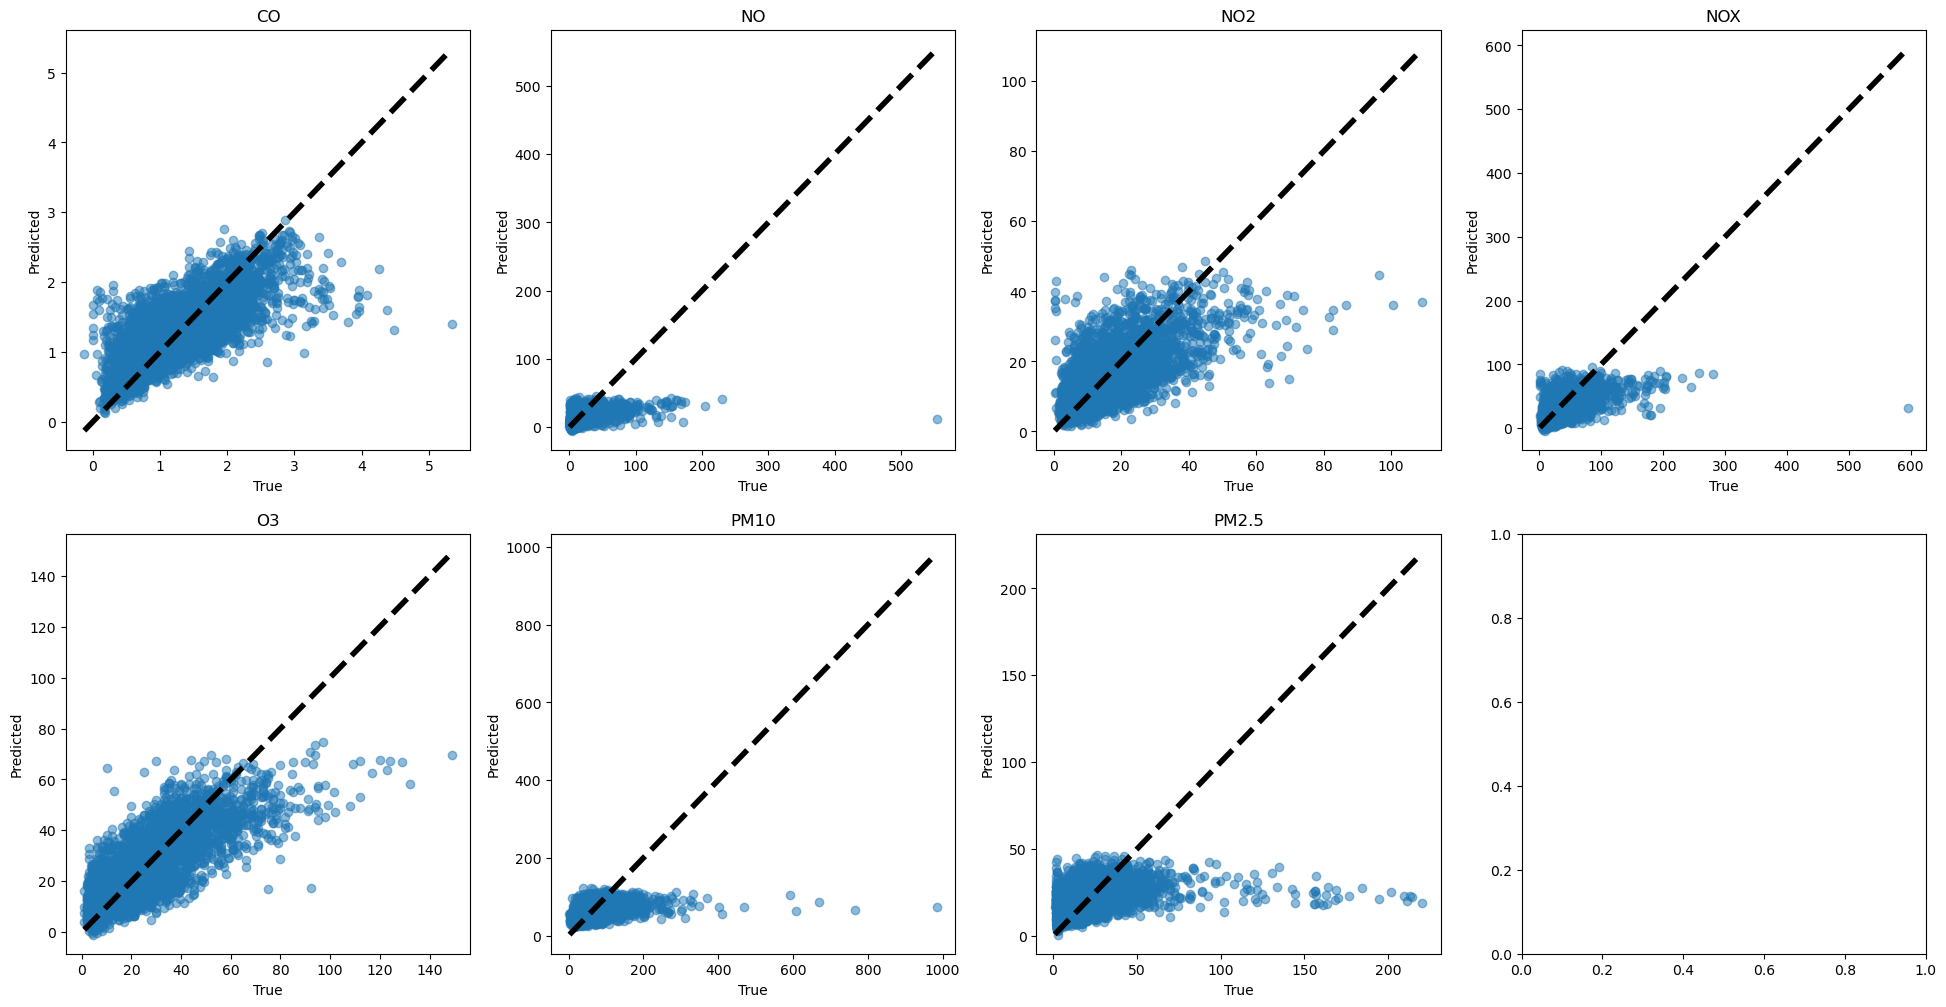

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(6*4, 6*2))

axes = axes.flatten()

for i in range(len(target_vars)):
    ax = axes[i]
    ax.scatter(y_test_np[:, i], y_pred_np[:, i], alpha=0.5)
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    ax.set_title(target_vars[i])
    ax.plot([y_test_np[:, i].min(), y_test_np[:, i].max()], [y_test_np[:, i].min(), y_test_np[:, i].max()], 'k--', lw=4)

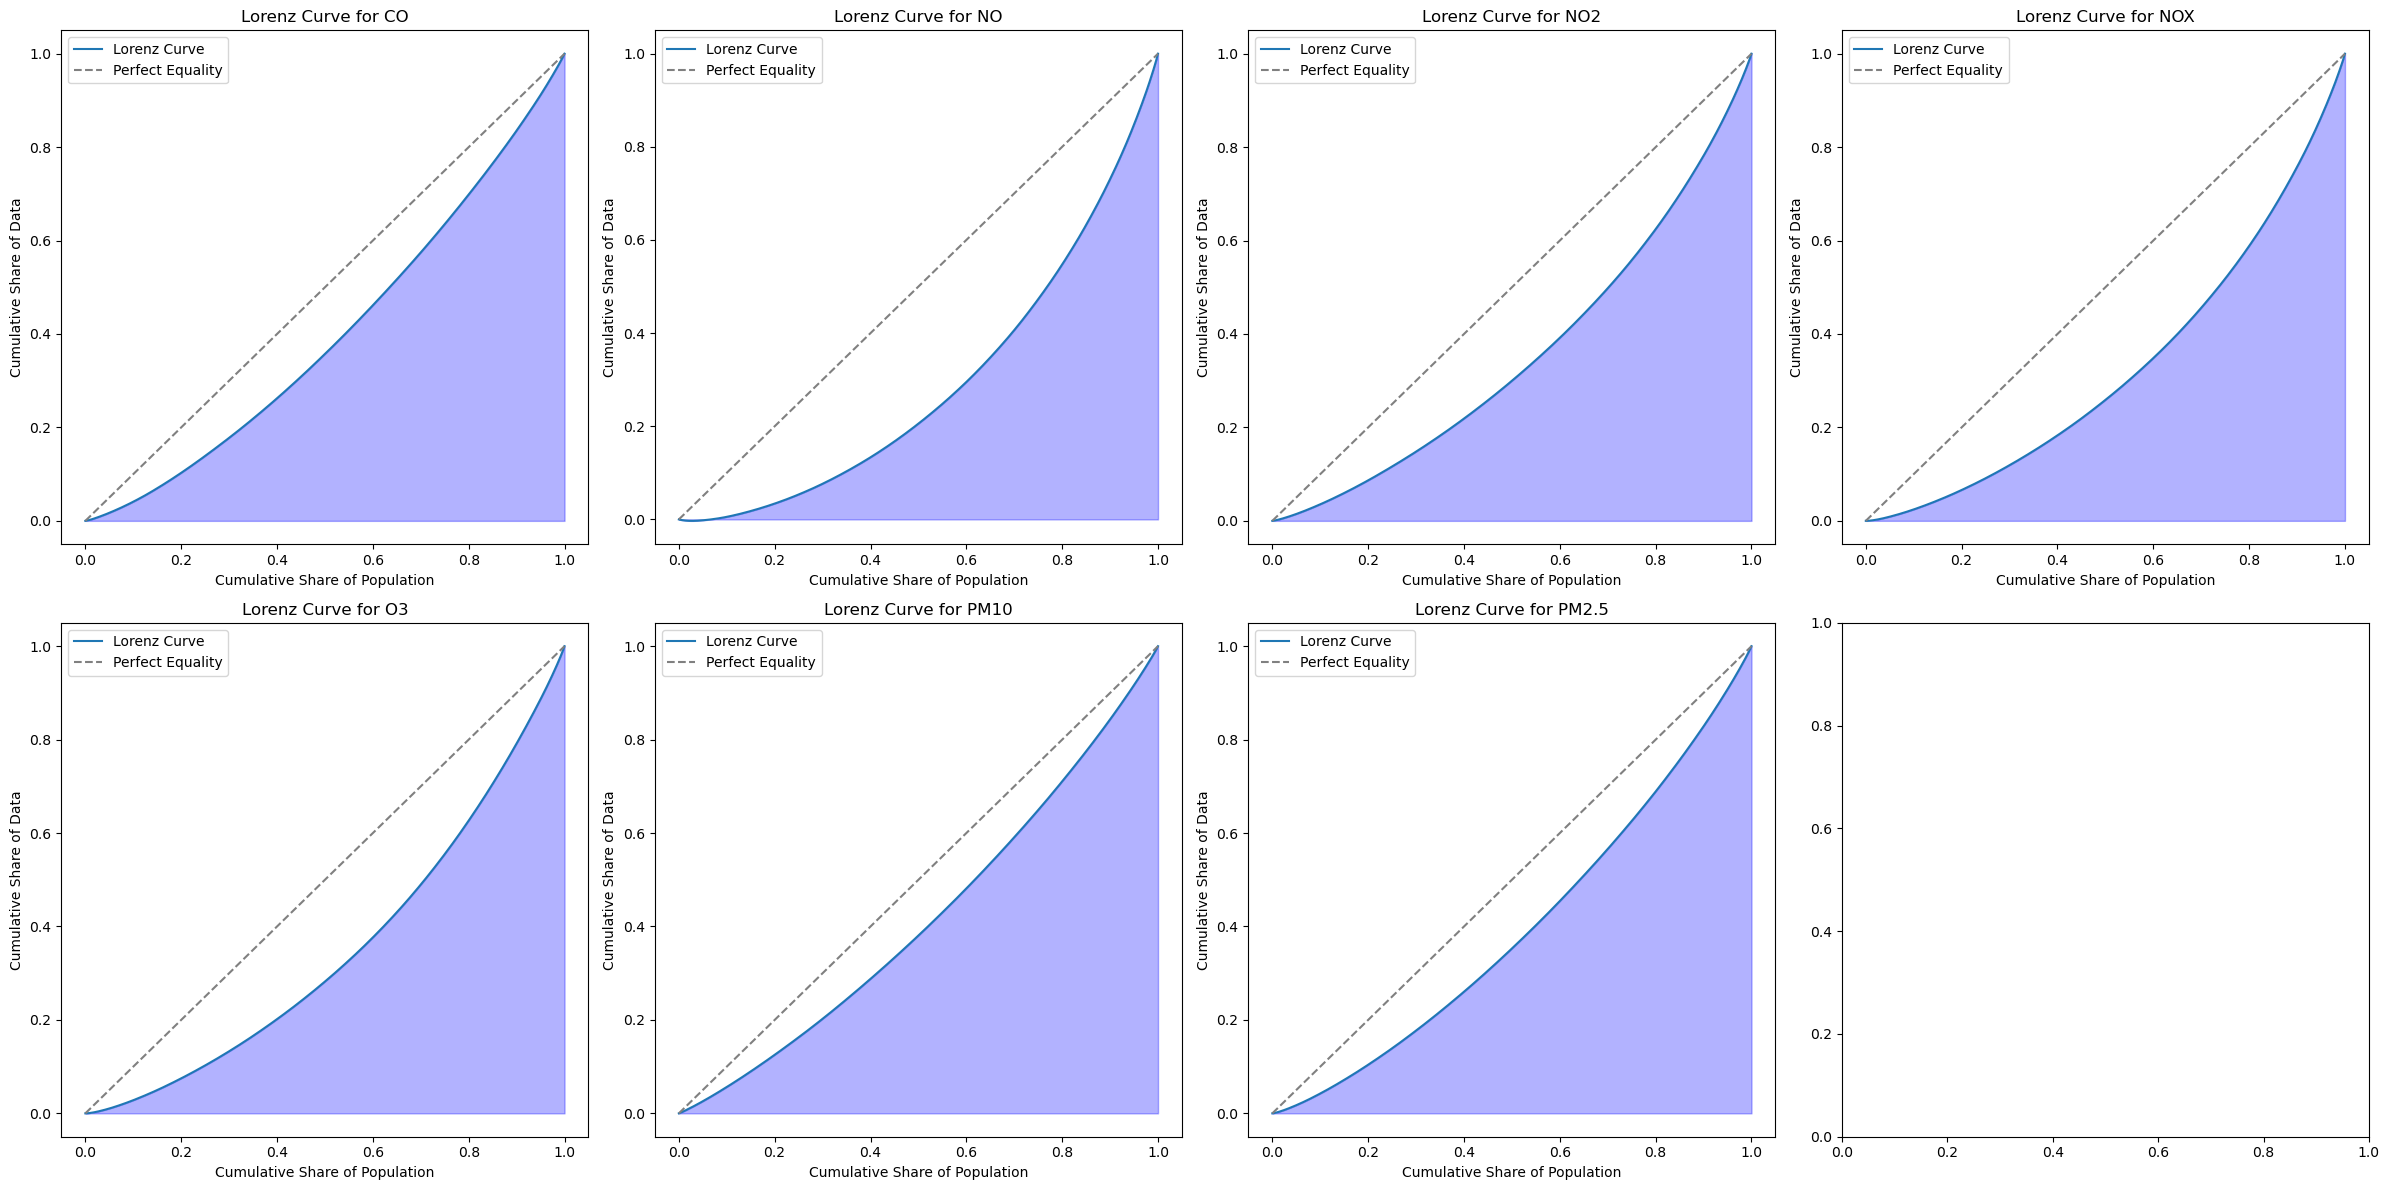

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(6*4, 6*2))

axes = axes.flatten()

for i in range(len(target_vars)):
    y_pred_ordered = np.sort(y_pred_np[:, i])
    y_pred_ordered = np.insert(y_pred_ordered, 0, 0)
    y_pred_lorenz = np.cumsum(y_pred_ordered) / np.sum(y_pred_ordered)

    x_vals = np.linspace(0, 1, len(y_pred_lorenz))
    
    axes[i].plot(x_vals, y_pred_lorenz, label='Lorenz Curve')
    axes[i].fill_between(x_vals, 0, y_pred_lorenz, alpha=0.3, color='blue')  # Fill under the Lorenz Curve
    axes[i].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Equality')
    axes[i].set_xlabel('Cumulative Share of Population')
    axes[i].set_ylabel('Cumulative Share of Data')
    axes[i].set_title(f'Lorenz Curve for {target_vars[i]}')
    axes[i].legend()

plt.tight_layout()
plt.show()